# Proyek Analisis Data: E-Commerce Public
- **Nama:** Rafael Simson Riston
- **Email:** rafaelsimsonriston@gmail.com
- **ID Dicoding:** rafaelsimsonr

## Determinig the Question

1. What is the percentage of product sales that weight more than 1 kg in the last six months?
2. What is the average review score for each product category in the last three months?
3. What are the sales trends for products by category over the last two years?
4. What is the geographical distribution of customers in the last year?


## 1. Import Packages

In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import FastMarkerCluster, HeatMap

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## 2. Data Wrangling

### 1. Gathering Data

In [3]:
customers_df = pd.read_csv(os.path.join(os.getcwd(), 'data/customers_dataset.csv'))
geo_df = pd.read_csv(os.path.join(os.getcwd(), 'data/geolocation_dataset.csv'))
order_items_df = pd.read_csv(os.path.join(os.getcwd(), 'data/order_items_dataset.csv'))
order_pay_df = pd.read_csv(os.path.join(os.getcwd(), 'data/order_payments_dataset.csv'))
order_reviews_df = pd.read_csv(os.path.join(os.getcwd(), 'data/order_reviews_dataset.csv'))
orders_df = pd.read_csv(os.path.join(os.getcwd(), 'data/orders_dataset.csv'))
product_category_name_df = pd.read_csv(os.path.join(os.getcwd(), 'data/product_category_name_translation.csv'))
products_df = pd.read_csv(os.path.join(os.getcwd(), 'data/products_dataset.csv'))
sellers_df = pd.read_csv(os.path.join(os.getcwd(), 'data/sellers_dataset.csv'))

### 2. Accesing Data

#### a. Find missing values and duplicate values

In [4]:
# Assign df_names and dataframes
dataframe_names = ['sellers_df', 'products_df', 'product_category_name_df', 
                'orders_df', 'order_reviews_df', 'order_pay_df', 
                'order_items_df', 'geo_df', 'customers_df']
dataframes = [sellers_df, products_df, product_category_name_df, orders_df, 
              order_reviews_df, order_pay_df, order_items_df, geo_df, customers_df]

In [148]:
def missing_values_check(dataframe_names, dataframes):

    # Create a dictionary to store check results
    datas_check = {
        'data_name': [], 
        'n_rows': [], 
        'n_cols': [], 
        'sum_null': [], 
        'sum_col_null':[], 
        'name_col_null':[], 
        'sum_duplicated':[], 
        'sum_col_duplicate':[],
        'name_col_duplicate':[]
    }

    # Loop through dataframes and perform checks
    for data_name, data in zip(dataframe_names, dataframes):
        datas_check['data_name'].append(data_name)
        datas_check['n_rows'].append(data.shape[0])
        datas_check['n_cols'].append(data.shape[1])
        datas_check['sum_null'].append(np.sum(data.isna().sum()))
        datas_check['sum_duplicated'].append(np.sum(data.duplicated()))
        
        # Initialize lists for storing column-wise null and duplicate information
        sum_col_null = []
        name_col_null = []
        sum_col_duplicate = []
        name_col_duplicate = []
        
        # Loop through columns of each dataframe
        for col in data.columns:
            # Count null values and duplicates for each column
            sum_col_null.append(np.sum(data[col].isna()))
            sum_col_duplicate.append(np.sum(data.duplicated().sum()))
        
        # Count columns with null and duplicate values
        sum_col_n = sum(n != 0 for n in sum_col_null)
        sum_col_d = sum(n != 0 for n in sum_col_duplicate)
        
        # Append column names with null and duplicate values
        for idx, (n_null, n_duplicate) in enumerate(zip(sum_col_null, sum_col_duplicate)):
            if n_null != 0:
                name_col_null.append(data.columns[idx])
            if n_duplicate != 0:
                name_col_duplicate.append(data.columns[idx])

        datas_check['sum_col_null'].append(sum_col_n)
        datas_check['name_col_null'].append(name_col_null)
        datas_check['sum_col_duplicate'].append(sum_col_d)
        datas_check['name_col_duplicate'].append(name_col_duplicate)

    # Convert dictionary to dataframe
    return pd.DataFrame(datas_check)


In [149]:
missing_values_check(dataframe_names, dataframes)

data_name   n_rows  n_cols  sum_null  sum_col_null  \
0                sellers_df     3095       4         0             0   
1               products_df    32340       9         0             0   
2  product_category_name_df       71       2         0             0   
3                 orders_df    99441       8      4908             3   
4          order_reviews_df    99224       7    145903             2   
5              order_pay_df   103886       5         0             0   
6            order_items_df   112650       7         0             0   
7                    geo_df  1000163       5         0             0   
8              customers_df    99441       5         0             0   

                                                                      name_col_null  \
0                                                                                []   
1                                                                                []   
2                                                                                []   
3  [order_approved_at, order_delivered_carrier_date, order_delivered_customer_date]   
4                                    [review_comment_title, review_comment_message]   
5                                                                                []   
6                                                                                []   
7                                                                                []   
8                                                                                []   

   sum_duplicated  sum_col_duplicate  \
0               0                  0   
1               0                  0   
2               0                  0   
3               0                  0   
4               0                  0   
5               0                  0   
6               0                  0   
7          261831                  5   
8               0                  0   

                                                                                     name_col_duplicate  
0                                                                                                    []  
1                                                                                                    []  
2                                                                                                    []  
3                                                                                                    []  
4                                                                                                    []  
5                                                                                                    []  
6                                                                                                    []  
7  [geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state]  
8                                                                                                    []

As you can see, there are a lot of missing values in the products dataset, orders, and reviews. On the other hand, duplicate values can be found in this data, specifically in the geographical dataset. However, this is normal because of the zip code, city, and state.

#### b. Check Data Types and Descriptive Statistics

In [121]:
# Initialize dict for store data
def describe_data(dataframe_names, dataframes):
    datas_describe = {
        'data_name':[],
        'column_name': [],
        'n_null':[],
        'n_null_%':[],
        'n_duplicated':[],
        'dtype': [],
        'count':[],
        'mean':[],
        'median':[],
        'min':[],
        'max':[]

    }

    # Use for loop to iterate to all dataframe
    for data_name, data in zip(dataframe_names, dataframes):
        for col in data.columns:
            n_null = data[col].isna().sum() 

            datas_describe['data_name'].append(data_name)
            datas_describe['column_name'].append(col)
            datas_describe['dtype'].append(str(data[col].dtype))  # Convert dtype to string
            datas_describe['count'].append(data[col].count())  # Use count() for non-null values count
            datas_describe['mean'].append(f"{np.mean(data[col]):.2f}" if data[col].dtype in ['int64','float64'] else "")  # Calculate mean for numeric columns
            datas_describe['min'].append(f"{np.min(data[col]):.2f}" if data[col].dtype in ['int64','float64'] else "")  # Calculate min for numeric columns
            datas_describe['max'].append(f"{np.max(data[col]):.2f}" if data[col].dtype in ['int64','float64'] else "")  # Calculate max for numeric columns
            datas_describe['median'].append(f"{np.median(data[col]):.2f}" if data[col].dtype == ['int','float'] else "")  # Calculate median for numeric columns
            datas_describe['n_null'].append(n_null) # Calculate null 
            datas_describe['n_null_%'].append(f'{round(n_null/len(data)*100)}%') # Calculate percentage null
            datas_describe['n_duplicated'].append(np.sum(data[col].duplicated()))

    # For the purpose of readability, using pandas dataframe is the solution
    return pd.DataFrame(datas_describe)


In [125]:
describe_data(dataframe_names,dataframes)

data_name                    column_name  n_null n_null_%  \
0                 sellers_df                      seller_id       0       0%   
1                 sellers_df         seller_zip_code_prefix       0       0%   
2                 sellers_df                    seller_city       0       0%   
3                 sellers_df                   seller_state       0       0%   
4                products_df                     product_id       0       0%   
5                products_df          product_category_name       0       0%   
6                products_df            product_name_lenght       0       0%   
7                products_df     product_description_lenght       0       0%   
8                products_df             product_photos_qty       0       0%   
9                products_df               product_weight_g       0       0%   
10               products_df              product_length_cm       0       0%   
11               products_df              product_height_cm       0       0%   
12               products_df               product_width_cm       0       0%   
13  product_category_name_df          product_category_name       0       0%   
14  product_category_name_df  product_category_name_english       0       0%   
15                 orders_df                       order_id       0       0%   
16                 orders_df                    customer_id       0       0%   
17                 orders_df                   order_status       0       0%   
18                 orders_df       order_purchase_timestamp       0       0%   
19                 orders_df              order_approved_at     160       0%   
20                 orders_df   order_delivered_carrier_date    1783       2%   
21                 orders_df  order_delivered_customer_date    2965       3%   
22                 orders_df  order_estimated_delivery_date       0       0%   
23          order_reviews_df                      review_id       0       0%   
24          order_reviews_df                       order_id       0       0%   
25          order_reviews_df                   review_score       0       0%   
26          order_reviews_df           review_comment_title   87656      88%   
27          order_reviews_df         review_comment_message   58247      59%   
28          order_reviews_df           review_creation_date       0       0%   
29          order_reviews_df        review_answer_timestamp       0       0%   
30              order_pay_df                       order_id       0       0%   
31              order_pay_df             payment_sequential       0       0%   
32              order_pay_df                   payment_type       0       0%   
33              order_pay_df           payment_installments       0       0%   
34              order_pay_df                  payment_value       0       0%   
35            order_items_df                       order_id       0       0%   
36            order_items_df                  order_item_id       0       0%   
37            order_items_df                     product_id       0       0%   
38            order_items_df                      seller_id       0       0%   
39            order_items_df            shipping_limit_date       0       0%   
40            order_items_df                          price       0       0%   
41            order_items_df                  freight_value       0       0%   
42                    geo_df    geolocation_zip_code_prefix       0       0%   
43                    geo_df                geolocation_lat       0       0%   
44                    geo_df                geolocation_lng       0       0%   
45                    geo_df               geolocation_city       0       0%   
46                    geo_df              geolocation_state       0       0%   
47              customers_df                    customer_id       0       0%   
48              customers_df             customer_unique_id       0       0%   
49              cus

There are many instances of incorrect data types and missing values in the order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, review_comment_title, review_comment_message, product_name_length, product_description_length, product_photos_qty, and product_category_name fields.

Most of the missing values are in string fields, with only a few in integer fields.

|         Column                | Data Type                 |           
| ----------------------------- | ------------------------- |
| order_purchase_timestamp      | **str** -> **datetime**   |
| order_approved_at             | **str** -> **datetime**   |
| order_delivered_carrier_date  | **str** -> **datetime**   |
| order_delivered_customer_date | **str** -> **datetime**   |
| order_estimated_delivery_date | **str** -> **datetime**   |
| review_creation_date          | **str** -> **datetime**   |
| review_answer_timestamp       | **str** -> **datetime**   |
| shipping_limit_date           | **str** -> **datetime**   |
| geolocation_zip_code_prefix   | **int** -> **str**        |
| customer_zip_code_prefix      | **int** -> **str**        |
| seller_zip_code_prefix        | **int** -> **str**        |


Also, check the payment_value column in the order payments data, because there are transactions with a payment of 0. There are zero values in the product_weight_g column in products_df, and in the freight_value column in order_items_df.

In [9]:
order_pay_df[order_pay_df['payment_value'] == order_pay_df['payment_value'].min()]

order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
94427   c8c528189310eaa44a745b8d9d26908b                   1  not_defined   
100766  b23878b3e8eb4d25a158f57d96331b18                   4      voucher   

        payment_installments  payment_value  
19922                      1            0.0  
36822                      1            0.0  
43744                      1            0.0  
51280                      1            0.0  
57411                      1            0.0  
62674                      1            0.0  
77885                      1            0.0  
94427                      1            0.0  
100766                     1            0.0

Most orders have a payment of 0 because of vouchers, but some have a payment_type that is not defined. So, try changing it to ‘voucher’.

In [10]:
# Check product_weight_g column
products_df[products_df['product_weight_g'] == products_df['product_weight_g'].min()]

product_id product_category_name  \
9769   81781c0fed9fe1ad6e8c81fca1e1cb08       cama_mesa_banho   
13683  8038040ee2a71048d4bdbbdc985b69ab       cama_mesa_banho   
14997  36ba42dd187055e1fbe943b2d11430ca       cama_mesa_banho   
32079  e673e90efa65a5409ff4196c038bb5af       cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
9769                  51.0                       529.0                 1.0   
13683                 48.0                       528.0                 1.0   
14997                 53.0                       528.0                 1.0   
32079                 53.0                       528.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
9769                0.0               30.0               25.0   
13683               0.0               30.0               25.0   
14997               0.0               30.0               25.0   
32079               0.0               30.0               25.0   

       product_width_cm  
9769               30.0  
13683              30.0  
14997              30.0  
32079              30.0

In [11]:
filter_volume = ((products_df['product_length_cm'] == 30) & (products_df['product_height_cm'] == 25) & (products_df['product_width_cm'] == 30))
filter_product_volume = (products_df['product_category_name'] == 'cama_mesa_banho') & filter_volume
products_df[filter_product_volume]

product_id product_category_name  \
1731   500909059ad72b36b2554150cc327edb       cama_mesa_banho   
9769   81781c0fed9fe1ad6e8c81fca1e1cb08       cama_mesa_banho   
13683  8038040ee2a71048d4bdbbdc985b69ab       cama_mesa_banho   
14997  36ba42dd187055e1fbe943b2d11430ca       cama_mesa_banho   
32079  e673e90efa65a5409ff4196c038bb5af       cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
1731                  39.0                      1140.0                 1.0   
9769                  51.0                       529.0                 1.0   
13683                 48.0                       528.0                 1.0   
14997                 53.0                       528.0                 1.0   
32079                 53.0                       528.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
1731             3100.0               30.0               25.0   
9769                0.0               30.0               25.0   
13683               0.0               30.0               25.0   
14997               0.0               30.0               25.0   
32079               0.0               30.0               25.0   

       product_width_cm  
1731               30.0  
9769               30.0  
13683              30.0  
14997              30.0  
32079              30.0

For product_weight_g column that has zero, we'll change the value into 3100 g

In [12]:
# Check freight_value 
order_items_df[order_items_df['freight_value'] == order_items_df['freight_value'].min()]

order_id  order_item_id  \
114     00404fa7a687c8c44ca69d42695aae73              1   
258     00a870c6c06346e85335524935c600c0              1   
483     011c899816ea29773525bd3322dbb6aa              1   
508     012b3f6ab7776a8ab3443a4ad7bef2e6              1   
509     012b3f6ab7776a8ab3443a4ad7bef2e6              2   
...                                  ...            ...   
111094  fc698f330ec7fb74859071cc6cb29772              1   
111497  fd4907109f6bac23f07064af84bec02d              1   
111649  fd95e4b85ebbb81853d4a6be3d61432b              1   
112182  fee19a0dc7358b6962a611cecf6a37b4              1   
112607  ffe73fc1d73e03fdb50e63903ddfe882              1   

                              product_id                         seller_id  \
114     53b36df67ebb7c41585e8d54d6772e08  7d13fca15225358621be4086e1eb0964   
258     aca2eb7d00ea1a7b8ebd4e68314663af  955fee9216a65b617aa5c0531780ce60   
483     53b36df67ebb7c41585e8d54d6772e08  7d13fca15225358621be4086e1eb0964   
508     422879e10f46682990de24d770e7f83d  1f50f920176fa81dab994f9023523100   
509     422879e10f46682990de24d770e7f83d  1f50f920176fa81dab994f9023523100   
...                                  ...                               ...   
111094  422879e10f46682990de24d770e7f83d  1f50f920176fa81dab994f9023523100   
111497  7a10781637204d8d10485c71a6108a2e  4869f7a5dfa277a7dca6462dcf3b52b2   
111649  53b36df67ebb7c41585e8d54d6772e08  4869f7a5dfa277a7dca6462dcf3b52b2   
112182  f1c7f353075ce59d8a6f3cf58f419c9c  37be5a7c751166fbc5f8ccba4119e043   
112607  53b36df67ebb7c41585e8d54d6772e08  4869f7a5dfa277a7dca6462dcf3b52b2   

        shipping_limit_date  price  freight_value  
114     2018-05-15 04:31:26   99.9            0.0  
258     2018-05-14 00:14:29   69.9            0.0  
483     2018-05-07 05:30:45   99.9            0.0  
508     2018-05-09 21:30:50   53.9            0.0  
509     2018-05-09 21:30:50   53.9            0.0  
...                     ...    ...            ...  
111094  2018-04-25 02:31:57   53.9            0.0  
111497  2018-04-30 11:31:32  219.0            0.0  
111649  2018-05-04 11:10:31  106.9            0.0  
112182  2017-09-07 22:06:31  195.0            0.0  
112607  2018-04-23 13:15:15  112.9            0.0  

[383 rows x 7 columns]

In [13]:
order_items_df[order_items_df['freight_value'] != order_items_df['freight_value'].min()]

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
0       2017-09-19 09:45:35   58.90          13.29  
1       2017-05-03 11:05:13  239.90          19.93  
2       2018-01-18 14:48:30  199.00          17.87  
3       2018-08-15 10:10:18   12.99          12.79  
4       2017-02-13 13:57:51  199.90          18.14  
...                     ...     ...            ...  
112645  2018-05-02 04:11:01  299.99          43.41  
112646  2018-07-20 04:31:48  350.00          36.53  
112647  2017-10-30 17:14:25   99.90          16.95  
112648  2017-08-21 00:04:32   55.99           8.72  
112649  2018-06-12 17:10:13   43.00          12.79  

[112267 rows x 7 columns]

In [14]:
order_items_df[order_items_df['freight_value'] == order_items_df['freight_value'].min()].shape[0] / order_items_df['freight_value'].shape[0] *100

0.33999112294718153

We could drop the rows with a freight_value of zero, because it wouldn’t ruined the information in our data. But for now just keep it

Next, check the product_category_name in products_df, and compare it to product_category_name_df

In [15]:
len(products_df['product_category_name'].unique())

74

In [16]:
len(product_category_name_df['product_category_name'])

71

There're three products different from product_category_name_df

In [17]:
# Filter product_df 
# if product name in products_df != product name in product_category_name_df return True (~) 
mask = ~products_df['product_category_name'].isin(product_category_name_df['product_category_name']) 
filtered_products_name_df = products_df[mask]
filtered_products_name_df['product_category_name'].unique()

array([nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'],
      dtype=object)

In [18]:
filtered_products_name_df.shape[0] / products_df.shape[0] * 100

1.890686170374192

We could drop it, as it would have no impact on our datasets, given that we would only lose 2% of the data.

### 3. Cleaning Data

Fix the incorrect data types

|         Column                | Data Type                 |  Dataset          |
| ----------------------------- | ------------------------- | ------------------|
| order_purchase_timestamp      | **str** -> **datetime**   | orders_df         |
| order_approved_at             | **str** -> **datetime**   | orders_df         |
| order_delivered_carrier_date  | **str** -> **datetime**   | orders_df         |
| order_delivered_customer_date | **str** -> **datetime**   | orders_df         |
| order_estimated_delivery_date | **str** -> **datetime**   | orders_df         |
| review_creation_date          | **str** -> **datetime**   | order_reviews_df  |
| review_answer_timestamp       | **str** -> **datetime**   | order_reviews_df  |
| shipping_limit_date           | **str** -> **datetime**   | order_items_df    |
| geolocation_zip_code_prefix   | **int** -> **str**        | geo_df	        |
| customer_zip_code_prefix      | **int** -> **str**        | customers_df      |
| seller_zip_code_prefix        | **int** -> **str**        | sellers_df        |

In [19]:
# Create a dictionary that maps column names to their new data types
column_dtype_mapping = {
    'orders_df': {
        'order_purchase_timestamp': 'datetime64[ns]',
        'order_approved_at': 'datetime64[ns]',
        'order_delivered_carrier_date': 'datetime64[ns]',
        'order_delivered_customer_date': 'datetime64[ns]',
        'order_estimated_delivery_date': 'datetime64[ns]'
    },
    'order_reviews_df': {
        'review_creation_date': 'datetime64[ns]',
        'review_answer_timestamp': 'datetime64[ns]'
    },
    'order_items_df': {
        'shipping_limit_date': 'datetime64[ns]'
    },
    'geo_df': {
        'geolocation_zip_code_prefix': 'str'
    },
    'customers_df': {
        'customer_zip_code_prefix': 'str'
    },
    'sellers_df': {
        'seller_zip_code_prefix': 'str'
    }
}

# Use a loop to apply the changes
for df_name, columns in column_dtype_mapping.items():
    for column, dtype in columns.items():
        globals()[df_name][column] = globals()[df_name][column].astype(dtype)


In [20]:
describe_data(dataframe_names, dataframes)

data_name                    column_name  n_null n_null_%  \
0                 sellers_df                      seller_id       0       0%   
1                 sellers_df         seller_zip_code_prefix       0       0%   
2                 sellers_df                    seller_city       0       0%   
3                 sellers_df                   seller_state       0       0%   
4                products_df                     product_id       0       0%   
5                products_df          product_category_name     610       2%   
6                products_df            product_name_lenght     610       2%   
7                products_df     product_description_lenght     610       2%   
8                products_df             product_photos_qty     610       2%   
9                products_df               product_weight_g       2       0%   
10               products_df              product_length_cm       2       0%   
11               products_df              product_height_cm       2       0%   
12               products_df               product_width_cm       2       0%   
13  product_category_name_df          product_category_name       0       0%   
14  product_category_name_df  product_category_name_english       0       0%   
15                 orders_df                       order_id       0       0%   
16                 orders_df                    customer_id       0       0%   
17                 orders_df                   order_status       0       0%   
18                 orders_df       order_purchase_timestamp       0       0%   
19                 orders_df              order_approved_at     160       0%   
20                 orders_df   order_delivered_carrier_date    1783       2%   
21                 orders_df  order_delivered_customer_date    2965       3%   
22                 orders_df  order_estimated_delivery_date       0       0%   
23          order_reviews_df                      review_id       0       0%   
24          order_reviews_df                       order_id       0       0%   
25          order_reviews_df                   review_score       0       0%   
26          order_reviews_df           review_comment_title   87656      88%   
27          order_reviews_df         review_comment_message   58247      59%   
28          order_reviews_df           review_creation_date       0       0%   
29          order_reviews_df        review_answer_timestamp       0       0%   
30              order_pay_df                       order_id       0       0%   
31              order_pay_df             payment_sequential       0       0%   
32              order_pay_df                   payment_type       0       0%   
33              order_pay_df           payment_installments       0       0%   
34              order_pay_df                  payment_value       0       0%   
35            order_items_df                       order_id       0       0%   
36            order_items_df                  order_item_id       0       0%   
37            order_items_df                     product_id       0       0%   
38            order_items_df                      seller_id       0       0%   
39            order_items_df            shipping_limit_date       0       0%   
40            order_items_df                          price       0       0%   
41            order_items_df                  freight_value       0       0%   
42                    geo_df    geolocation_zip_code_prefix       0       0%   
43                    geo_df                geolocation_lat       0       0%   
44                    geo_df                geolocation_lng       0       0%   
45                    geo_df               geolocation_city       0       0%   
46                    geo_df              geolocation_state       0       0%   
47              customers_df                    customer_id       0       0%   
48              customers_df             customer_unique_id       0       0%   
49              cus

In [21]:
# Filter order_pay_df that contain payment_type not_defined and payment_value of zero.
order_pay_not_defined = (order_pay_df['payment_type'] == 'not_defined') & (order_pay_df['payment_value'] == order_pay_df['payment_value'].min())

In [22]:
# Replace not_defined to voucher
order_pay_df.loc[order_pay_not_defined, :] = order_pay_df.loc[order_pay_not_defined, :].replace('not_defined', 'voucher')

In [23]:
order_pay_df[order_pay_df['payment_value'] == order_pay_df['payment_value'].min()]

order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1      voucher   
57411   00b1cb0320190ca0daa2c88b35206009                   1      voucher   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
94427   c8c528189310eaa44a745b8d9d26908b                   1      voucher   
100766  b23878b3e8eb4d25a158f57d96331b18                   4      voucher   

        payment_installments  payment_value  
19922                      1            0.0  
36822                      1            0.0  
43744                      1            0.0  
51280                      1            0.0  
57411                      1            0.0  
62674                      1            0.0  
77885                      1            0.0  
94427                      1            0.0  
100766                     1            0.0

We fixed the payment_type

In [24]:
# Remove missing value in products_df
products_df.dropna(axis=0, inplace=True)

In [25]:
products_df[mask.reindex(products_df.index)]

product_id  \
1628   0105b5323d24fc655f73052694dbbb3a   
5821   6fd83eb3e0799b775e4f946bd66657c0   
7325   5d923ead886c44b86845f69e50520c3e   
7478   6727051471a0fc4a0e7737b57bff2549   
8819   bed164d9d628cf0593003389c535c6e0   
11039  1220978a08a6b29a202bc015b18250e9   
14266  ae62bb0f95af63d64eae5f93dddea8d3   
16182  1954739d84629e7323a4295812a3e0ec   
16930  dbe520fb381ad695a7e1f2807d20c765   
17800  c7a3f1a7f9eef146cc499368b578b884   
18610  7afdd65f79f63819ff5bee328843fa37   
26890  a4756663d007b0cd1af865754d08d968   
29919  cb9d764f38ee4d0c00af64d5c388f837   

                               product_category_name  product_name_lenght  \
1628                                        pc_gamer                 59.0   
5821   portateis_cozinha_e_preparadores_de_alimentos                 52.0   
7325   portateis_cozinha_e_preparadores_de_alimentos                 58.0   
7478                                        pc_gamer                 60.0   
8819   portateis_cozinha_e_preparadores_de_alimentos                 54.0   
11039  portateis_cozinha_e_preparadores_de_alimentos                 46.0   
14266  portateis_cozinha_e_preparadores_de_alimentos                 59.0   
16182  portateis_cozinha_e_preparadores_de_alimentos                 58.0   
16930                                       pc_gamer                 60.0   
17800  portateis_cozinha_e_preparadores_de_alimentos                 52.0   
18610  portateis_cozinha_e_preparadores_de_alimentos                 48.0   
26890  portateis_cozinha_e_preparadores_de_alimentos                 60.0   
29919  portateis_cozinha_e_preparadores_de_alimentos                 57.0   

       product_description_lenght  product_photos_qty  product_weight_g  \
1628                        621.0                 4.0            2839.0   
5821                        280.0                 1.0            1200.0   
7325                        284.0                 1.0            1200.0   
7478                       1532.0                 3.0             650.0   
8819                        382.0                 2.0             850.0   
11039                       280.0                 1.0            1200.0   
14266                       927.0                 1.0           10600.0   
16182                       792.0                 4.0             750.0   
16930                       840.0                 6.0             800.0   
17800                      1372.0                 5.0            7350.0   
18610                       305.0                 1.0             750.0   
26890                      1304.0                 4.0             650.0   
29919                       306.0                 1.0             625.0   

       product_length_cm  product_height_cm  product_width_cm  
1628                19.0               16.0              18.0  
5821                25.0               33.0              25.0  
7325                25.0               33.0              25.0  
7478                16.0               22.0              20.0  
8819                30.0               21.0              22.0  
11039               25.0               33.0              25.0  
14266               40.0               20.0              38.0  
16182               30.0               30.0              30.0  
16930               18.0               22.0              22.0  
17800               40.0               30.0              23.0  
18610               20.0               20.0              20.0  
26890               22.0                6.0              14.0  
29919               28.0               27.0              24.0

In [26]:
# Remove product_category_name
products_df = products_df[~mask.reindex(products_df.index)]

We fixed the missing product_category_name

In [27]:
products_df[filter_product_volume]

C:\Users\rafae\AppData\Local\Temp\ipykernel_26344\4041168729.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  products_df[filter_product_volume]


product_id product_category_name  \
1731   500909059ad72b36b2554150cc327edb       cama_mesa_banho   
9769   81781c0fed9fe1ad6e8c81fca1e1cb08       cama_mesa_banho   
13683  8038040ee2a71048d4bdbbdc985b69ab       cama_mesa_banho   
14997  36ba42dd187055e1fbe943b2d11430ca       cama_mesa_banho   
32079  e673e90efa65a5409ff4196c038bb5af       cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
1731                  39.0                      1140.0                 1.0   
9769                  51.0                       529.0                 1.0   
13683                 48.0                       528.0                 1.0   
14997                 53.0                       528.0                 1.0   
32079                 53.0                       528.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
1731             3100.0               30.0               25.0   
9769                0.0               30.0               25.0   
13683               0.0               30.0               25.0   
14997               0.0               30.0               25.0   
32079               0.0               30.0               25.0   

       product_width_cm  
1731               30.0  
9769               30.0  
13683              30.0  
14997              30.0  
32079              30.0

In [28]:
products_df.loc[filter_product_volume & (products_df['product_weight_g'] == 0), 'product_weight_g'] = 3100

We fixed the product_weight_g in products_df

Check the dimensions of geo_df and remove duplicated values in the zip code because the zip code is a unique identifier for geographical locations.

In [29]:
# Check the dimensions before removing duplicates
geo_df.shape

(1000163, 5)

In [30]:
# Check how much duplicated values in zip code
geo_df['geolocation_zip_code_prefix'].duplicated().sum()

981148

In [31]:
# Remove duplicates
geo_df = geo_df.drop_duplicates(subset='geolocation_zip_code_prefix', keep='last')
geo_df

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
950                            1029       -23.539609       -46.632911   
962                            1006       -23.550317       -46.636604   
1127                           1038       -23.544340       -46.640552   
1133                           1018       -23.551846       -46.633756   
1156                           1022       -23.547795       -46.630238   
...                             ...              ...              ...   
1000153                       99970       -28.343273       -51.873734   
1000155                       99965       -28.180655       -52.034367   
1000159                       99900       -27.877125       -52.224882   
1000161                       99980       -28.388932       -51.846871   
1000162                       99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  
950            sao paulo                SP  
962            são paulo                SP  
1127           sao paulo                SP  
1133           sao paulo                SP  
1156           sao paulo                SP  
...                  ...               ...  
1000153          ciriaco                RS  
1000155       agua santa                RS  
1000159   getulio vargas                RS  
1000161  david canabarro                RS  
1000162         tapejara                RS  

[19015 rows x 5 columns]

## 3. Explonatory Data Analysis

In [32]:
describe_data(dataframe_names,dataframes)[['data_name','column_name']]

data_name                    column_name
0                 sellers_df                      seller_id
1                 sellers_df         seller_zip_code_prefix
2                 sellers_df                    seller_city
3                 sellers_df                   seller_state
4                products_df                     product_id
5                products_df          product_category_name
6                products_df            product_name_lenght
7                products_df     product_description_lenght
8                products_df             product_photos_qty
9                products_df               product_weight_g
10               products_df              product_length_cm
11               products_df              product_height_cm
12               products_df               product_width_cm
13  product_category_name_df          product_category_name
14  product_category_name_df  product_category_name_english
15                 orders_df                       order_id
16                 orders_df                    customer_id
17                 orders_df                   order_status
18                 orders_df       order_purchase_timestamp
19                 orders_df              order_approved_at
20                 orders_df   order_delivered_carrier_date
21                 orders_df  order_delivered_customer_date
22                 orders_df  order_estimated_delivery_date
23          order_reviews_df                      review_id
24          order_reviews_df                       order_id
25          order_reviews_df                   review_score
26          order_reviews_df           review_comment_title
27          order_reviews_df         review_comment_message
28          order_reviews_df           review_creation_date
29          order_reviews_df        review_answer_timestamp
30              order_pay_df                       order_id
31              order_pay_df             payment_sequential
32              order_pay_df                   payment_type
33              order_pay_df           payment_installments
34              order_pay_df                  payment_value
35            order_items_df                       order_id
36            order_items_df                  order_item_id
37            order_items_df                     product_id
38            order_items_df                      seller_id
39            order_items_df            shipping_limit_date
40            order_items_df                          price
41            order_items_df                  freight_value
42                    geo_df    geolocation_zip_code_prefix
43                    geo_df                geolocation_lat
44                    geo_df                geolocation_lng
45                    geo_df               geolocation_city
46                    geo_df              geolocation_state
47              customers_df                    customer_id
48              customers_df             customer_unique_id
49              customers_df       customer_zip_code_prefix
50              customers_df                  customer_city
51              customers_df                 customer_state

Combine all dataframes and select only the features necessary for analysis.

In [33]:
all_df = pd.merge(orders_df, order_items_df, on='order_id')
all_df = pd.merge(all_df, sellers_df, on='seller_id')
all_df = pd.merge(all_df, order_pay_df, on='order_id')
all_df = pd.merge(all_df, order_reviews_df, on='order_id')
all_df = pd.merge(all_df, products_df, on='product_id')
all_df = pd.merge(all_df, customers_df, on='customer_id')
all_df = pd.merge(all_df, product_category_name_df, on='product_category_name')
all_df = pd.merge(all_df, geo_df, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
all_df = pd.merge(all_df, geo_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
all_df.shape

(115036, 50)

Remove and rename the columns that are necessary.|

In [34]:
# Remove columns
all_df.drop(columns=['review_answer_timestamp', 'review_creation_date', 'review_comment_message','review_comment_title', 
                    'customer_zip_code_prefix', 'seller_zip_code_prefix','product_category_name','review_id', 'product_description_lenght', 
                     'product_name_lenght', 'product_photos_qty', 'product_name_lenght', 'payment_installments', 'geolocation_city_x',
                    'geolocation_state_x', 'geolocation_state_y', 'geolocation_city_y'], inplace=True)
# Rename Columns
all_df.rename(columns={
    'geolocation_zip_code_prefix_x':'zip_code_customer',
    'geolocation_zip_code_prefix_y':'zip_code_seller',
    'geolocation_lat_x':'customer_lat',
    'geolocation_lng_x':'customer_lng',
    'geolocation_lat_y':'seller_lat',
    'geolocation_lng_y':'seller_lng',
},inplace=True)

all_df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18              1   
1                    2017-10-18              1   
2                    2017-10-18              1   
3                    2018-08-13              1   
4                    2018-09-04              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   

  shipping_limit_date   price  freight_value     seller_city seller_state  \
0 2017-10-06 11:07:15   29.99           8.72            maua           SP   
1 2017-10-06 11:07:15   29.99           8.72            maua           SP   
2 2017-10-06 11:07:15   29.99           8.72            maua           SP   
3 2018-07-30 03:24:27  118.70          22.76  belo horizonte           SP   
4 2018-08-13 08:55:23  159.90          19.22         guariba           SP   

   payment_sequential payment_type  payment_value  review_score  \
0                   1  credit_card          18.12             4   
1                   3      voucher           2.00             4   
2                   2      voucher          18.59             4   
3                   1       boleto         141.46             4   
4                   1  credit_card         179.12             5   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             500.0               19.0                8.0              13.0   
1             500.0               19.0                8.0              13.0   
2             500.0               19.0                8.0              13.0   
3             400.0               19.0               13.0              19.0   
4             420.0               24.0               19.0              21.0   

                 customer_unique_id customer_city customer_state  \
0  7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
1  7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
2  7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
3  af07308b275d755c9edb36a90c618231     barreiras             BA   
4  3a653a41f6f9fc3d2a113cf8398680e8    vianopolis             GO   

  product_category_name_english zip_code_customer  customer_lat  customer_lng  \
0                    housewares              3149    -23.583452    -46.586284   
1                    housewares              3149    -23.583452    -46.586284   
2                    housewares              3149    -23.583452    -46.586284   
3         

In [35]:
# Filter data based on seller_city using pivot or groupby
all_df.groupby(by='seller_city').agg({
    'order_id': 'nunique',
    'payment_value': ['mean','max','min']
}).sort_values(by=('order_id', 'nunique'),ascending=False).head()

order_id payment_value                
                nunique          mean       max   min
seller_city                                          
sao paulo         24026    144.036762  13664.08  0.01
ibitinga           6455    128.751346   1861.26  0.11
santo andre        2682    112.023474   1978.18  0.00
curitiba           2669    208.263415   3076.13  1.28
belo horizonte     2318    112.181051   3736.22  0.01

There are so many sellers from Sao Paulo, Ibitinga, Santo Andre and Curitiba

In [36]:
# Filter data based on customer_city using pivot or groupby
all_df.groupby(by='customer_city').agg({
    'order_id': 'nunique',
    'payment_value': ['mean','max','min']
}).sort_values(by=('order_id', 'nunique'),ascending=False).head()

order_id payment_value                
                nunique          mean       max   min
customer_city                                        
sao paulo         15010    153.803169   4513.32  0.01
rio de janeiro     6619    191.701207  13664.08  0.00
belo horizonte     2675    153.637031   3351.35  0.01
brasilia           1908    173.748090   3736.22  0.67
curitiba           1482    183.335207   3126.50  0.20

There are also many customers in Sao Paulo, Rio de Janeiro, Belo Horizonte, Brasilia, and Curitiba

In [37]:
# Filter data based on order_status using pivot or groupby
all_df.groupby(by='order_status').agg({
    'order_id': 'nunique',
    'payment_value': ['mean','max','min']
}).sort_values(by=('order_id', 'nunique'),ascending=False).head()

order_id payment_value                
              nunique          mean       max   min
order_status                                       
delivered       94018    171.607740  13664.08  0.00
shipped          1002    158.757120   2360.42  0.00
canceled          426    266.752377   4809.44  0.33
invoiced          298    223.472254   1827.72  1.02
processing        283    270.506685   2566.90  0.17

In [38]:
# Filter data based on product_category using pivot or groupby
all_df.groupby(by='product_category_name_english').agg({
    'order_id': 'nunique',
    'payment_value': ['mean','max','min']
}).sort_values(by=('order_id', 'nunique'),ascending=False).head(10)

order_id payment_value               
                               nunique          mean      max   min
product_category_name_english                                      
bed_bath_table                    9295    145.550118  2225.69  0.01
health_beauty                     8741    165.728546  2938.17  0.03
sports_leisure                    7653    155.547542  4163.51  0.00
computers_accessories             6632    195.427430  3736.22  0.01
furniture_decor                   6381    163.317275  2276.10  0.01
housewares                        5825    149.009921  6929.31  0.01
watches_gifts                     5554    230.438462  4445.50  0.23
telephony                         4143    102.390360  2457.44  0.01
auto                              3868    184.281512  2480.58  0.22
toys                              3820    144.347181  1782.55  0.01

In [39]:
# Filter data based on payment_type using pivot or groupby
all_df.groupby(by='payment_type').agg({
    'order_id': 'nunique',
    'payment_value': ['mean','max','min']
}).sort_values(by=('order_id', 'nunique'),ascending=False)

order_id payment_value                 
              nunique          mean       max    min
payment_type                                        
credit_card     73947    179.474720  13664.08   0.01
boleto          19111    176.856672   7274.88  11.62
voucher          3657     64.238536   1839.05   0.00
debit_card       1481    150.395390   4445.50  13.38

In [40]:
# create year of order
all_df['order_purchase_year'] = all_df['order_purchase_timestamp'].dt.year

In [41]:
# create month name of order
all_df['order_purchase_month_name'] = all_df['order_purchase_timestamp'].dt.month_name()

In [42]:
# create day name of order
all_df['order_purchase_day_name'] = all_df['order_purchase_timestamp'].dt.day_name()

In [43]:
# create function to get purchacse time
def get_part_of_day(hour):
    if (hour >= 4) and (hour < 12):
        return 'morning'
    elif (hour >= 12) and (hour < 17):
        return 'afternoon'
    elif (hour >= 17) and (hour < 21):
        return 'evening'
    else:
        return 'night'

In [44]:
all_df['part_of_day'] = all_df['order_purchase_timestamp'].dt.hour.apply(get_part_of_day)

In [45]:
# Filter data based on part of day using pivot or groupby
all_df.groupby(by='part_of_day').agg({
    'order_id': 'nunique',
    'payment_value': ['mean','max','min']
}).sort_values(by=('order_id', 'nunique'),ascending=False)

order_id payment_value                
             nunique          mean       max   min
part_of_day                                       
afternoon      31103    181.532258  13664.08  0.00
evening        23281    171.416837   6929.31  0.00
morning        21845    171.436250   6081.54  0.01
night          19806    160.099281   4513.32  0.00

In [46]:
# Filter data based on day using pivot or groupby
all_df.groupby(by='order_purchase_day_name').agg({
    'order_id': 'nunique',
    'payment_value': ['mean','max','min']
}).sort_values(by=('order_id', 'nunique'),ascending=False)

order_id payment_value                
                         nunique          mean       max   min
order_purchase_day_name                                       
Monday                     15633    172.502524   3979.55  0.01
Tuesday                    15421    173.800413   4764.34  0.01
Wednesday                  14977    169.184089   6726.66  0.00
Thursday                   14278    176.249072   4809.44  0.00
Friday                     13655    180.273408  13664.08  0.01
Sunday                     11579    163.512243   7274.88  0.01
Saturday                   10492    168.727756   4950.34  0.00

In [47]:
# Filter data based on month using pivot or groupby
all_df.groupby(by='order_purchase_month_name').agg({
    'order_id': 'nunique',
    'payment_value': ['mean','max','min']
}).sort_values(by=('order_id', 'nunique'),ascending=False)

order_id payment_value                
                           nunique          mean       max   min
order_purchase_month_name                                       
August                       10538    163.131369   4513.32  0.01
May                          10272    177.158776   6726.66  0.00
July                         10024    171.559840   7274.88  0.01
March                         9531    170.488720   4175.26  0.13
June                          9200    170.316614   4681.78  0.00
April                         9070    180.953909   4950.34  0.00
February                      8161    165.342628   6929.31  0.23
January                       7710    166.969554   3826.80  0.00
November                      7249    175.406735   6081.54  0.03
December                      5405    158.967215   2734.66  0.17
October                       4748    181.927845   3126.50  0.00
September                     4127    200.428133  13664.08  0.23

In [ ]:
# Filter data based on year using pivot or groupby
all_df.groupby(by='order_purchase_year').agg({
    'order_id': 'nunique',
    'payment_value': ['mean','max','min']
}).sort_values(by=('order_id', 'nunique'),ascending=False)

In [49]:
all_df

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                  ...                               ...   
115031  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
115032  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
115033  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
115034  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
115035  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp   order_approved_at  \
0         delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1         delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2         delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3         delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4         delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
...             ...                      ...                 ...   
115031    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
115032    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
115033    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
115034    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
115035    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2017-10-04 19:55:00           2017-10-10 21:25:13   
2               2017-10-04 19:55:00           2017-10-10 21:25:13   
3               2018-07-26 14:31:00           2018-08-07 15:27:45   
4               2018-08-08 13:50:00           2018-08-17 18:06:29   
...                             ...                           ...   
115031          2018-02-07 23:22:42           2018-02-28 17:37:56   
115032          2017-08-28 20:52:26           2017-09-21 11:24:17   
115033          2018-01-12 15:35:03           2018-01-25 23:32:54   
115034          2018-01-12 15:35:03           2018-01-25 23:32:54   
115035          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date  order_item_id  \
0                         2017-10-18              1   
1                         2017-10-18              1   
2                         2017-10-18              1   
3                         2018-08-13              1   
4                         2018-09-04              1   
...                              ...            ...   
115031                    2018-03-02              1   
115032                    2017-09-27              1   
115033                    2018-02-15              1   
115034                    2018-02-15              2   
115035                    2018-04-03              1   

                              product_id                         seller_id  \
0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
...                                  ...                               ...   
115031  f1d4ce8c6dd66c47bbaa8c6781c2a923  1f9ab4708f3056ede07124aad39a2554   
115032  b80910977a37536adeddd63663f916ad  d50d79cb34e38265a8649c383dcffd48   
115033  d1c427060a0f73f6b889a5c7c61f2ac4  a1043bafd471dff536d0c462352beb48   
115034  

## 4. Data Visualization & Explanatory Data Analysis

### 1. What is the percentage of product sales that weight more than 1 kg in the last six months?

In [50]:
all_df.loc[all_df['order_item_id'] == 20, ['order_item_id','price','freight_value', 'payment_value','product_weight_g']].iloc[0]

order_item_id         20.00
price                100.00
freight_value         10.12
payment_value       2202.40
product_weight_g     360.00
Name: 100528, dtype: float64

We calculate the payment_value by multiplying the order_item_id by the price, and then adding the product by multiplying  freight and order_item_id. This implies that the total weight for shipping is obtained by multiplying order_item_id and product_weight_g.

In [51]:
# Calculate the total weight shipping in gram
all_df['total_weight_shipping_g'] = all_df['product_weight_g'] * all_df['order_item_id']
all_df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18              1   
1                    2017-10-18              1   
2                    2017-10-18              1   
3                    2018-08-13              1   
4                    2018-09-04              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   

  shipping_limit_date   price  freight_value     seller_city seller_state  \
0 2017-10-06 11:07:15   29.99           8.72            maua           SP   
1 2017-10-06 11:07:15   29.99           8.72            maua           SP   
2 2017-10-06 11:07:15   29.99           8.72            maua           SP   
3 2018-07-30 03:24:27  118.70          22.76  belo horizonte           SP   
4 2018-08-13 08:55:23  159.90          19.22         guariba           SP   

   payment_sequential payment_type  payment_value  review_score  \
0                   1  credit_card          18.12             4   
1                   3      voucher           2.00             4   
2                   2      voucher          18.59             4   
3                   1       boleto         141.46             4   
4                   1  credit_card         179.12             5   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             500.0               19.0                8.0              13.0   
1             500.0               19.0                8.0              13.0   
2             500.0               19.0                8.0              13.0   
3             400.0               19.0               13.0              19.0   
4             420.0               24.0               19.0              21.0   

                 customer_unique_id customer_city customer_state  \
0  7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
1  7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
2  7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
3  af07308b275d755c9edb36a90c618231     barreiras             BA   
4  3a653a41f6f9fc3d2a113cf8398680e8    vianopolis             GO   

  product_category_name_english zip_code_customer  customer_lat  customer_lng  \
0                    housewares              3149    -23.583452    -46.586284   
1                    housewares              3149    -23.583452    -46.586284   
2                    housewares              3149    -23.583452    -46.586284   
3         

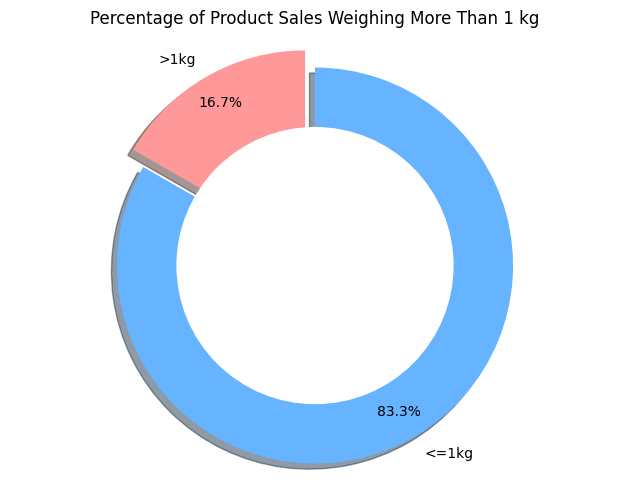

In [52]:
# Calculate the total count of product sales
total_sales = all_df['total_weight_shipping_g'].count()

# Calculate the date 6 months ago
six_months_ago = all_df['order_approved_at'].max() - pd.DateOffset(months=6)

# Calculate the count of product sales that weigh more than 1 kg
count_wght_shipp_upper = all_df['total_weight_shipping_g'][(all_df['total_weight_shipping_g'] >= 1000) & 
                                                           (all_df['order_approved_at'] >= six_months_ago)].count()
# Calculate the percentage
percentage = (count_wght_shipp_upper / total_sales) * 100

# Define colors and explode parameters
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode 1st slice

# Create a pie chart
plt.pie([percentage, 100-percentage], labels=['>1kg', '<=1kg'], autopct='%1.1f%%', startangle=90, pctdistance=0.85, colors=colors, explode=explode, shadow=True)

# Draw a circle at the center (for donut chart)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.title('Percentage of Product Sales Weighing More Than 1 kg')
plt.show()

Most of product less than 1 kg 

### 2. What is the average review score for each product category in the last three months?

In [53]:
# Calculate the date 3 months ago
three_months_ago = all_df['order_approved_at'].max() - pd.DateOffset(months=3)

# Filter DataFrame for rows where 'order_approved_at' is within the last three months
recent_df = all_df[all_df['order_approved_at'] >= three_months_ago]

# Calculate the average review score for each product category
average_review_scores = recent_df.groupby('product_category_name_english')['review_score'].mean()

# Print the result
average_review_scores

product_category_name_english
agro_industry_and_commerce    3.932203
air_conditioning              3.603774
art                           4.073529
arts_and_craftmanship         4.050000
audio                         4.342857
                                ...   
stationery                    4.449057
tablets_printing_image        4.000000
telephony                     4.040055
toys                          4.290944
watches_gifts                 4.116084
Name: review_score, Length: 68, dtype: float64

C:\Users\rafae\AppData\Local\Temp\ipykernel_26344\2810386864.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values[::-1], y=top_10.index[::-1], ax=axs[0], palette="Blues_d")
C:\Users\rafae\AppData\Local\Temp\ipykernel_26344\2810386864.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_10.values[::-1], y=bottom_10.index[::-1], ax=axs[1], palette="Blues_d")


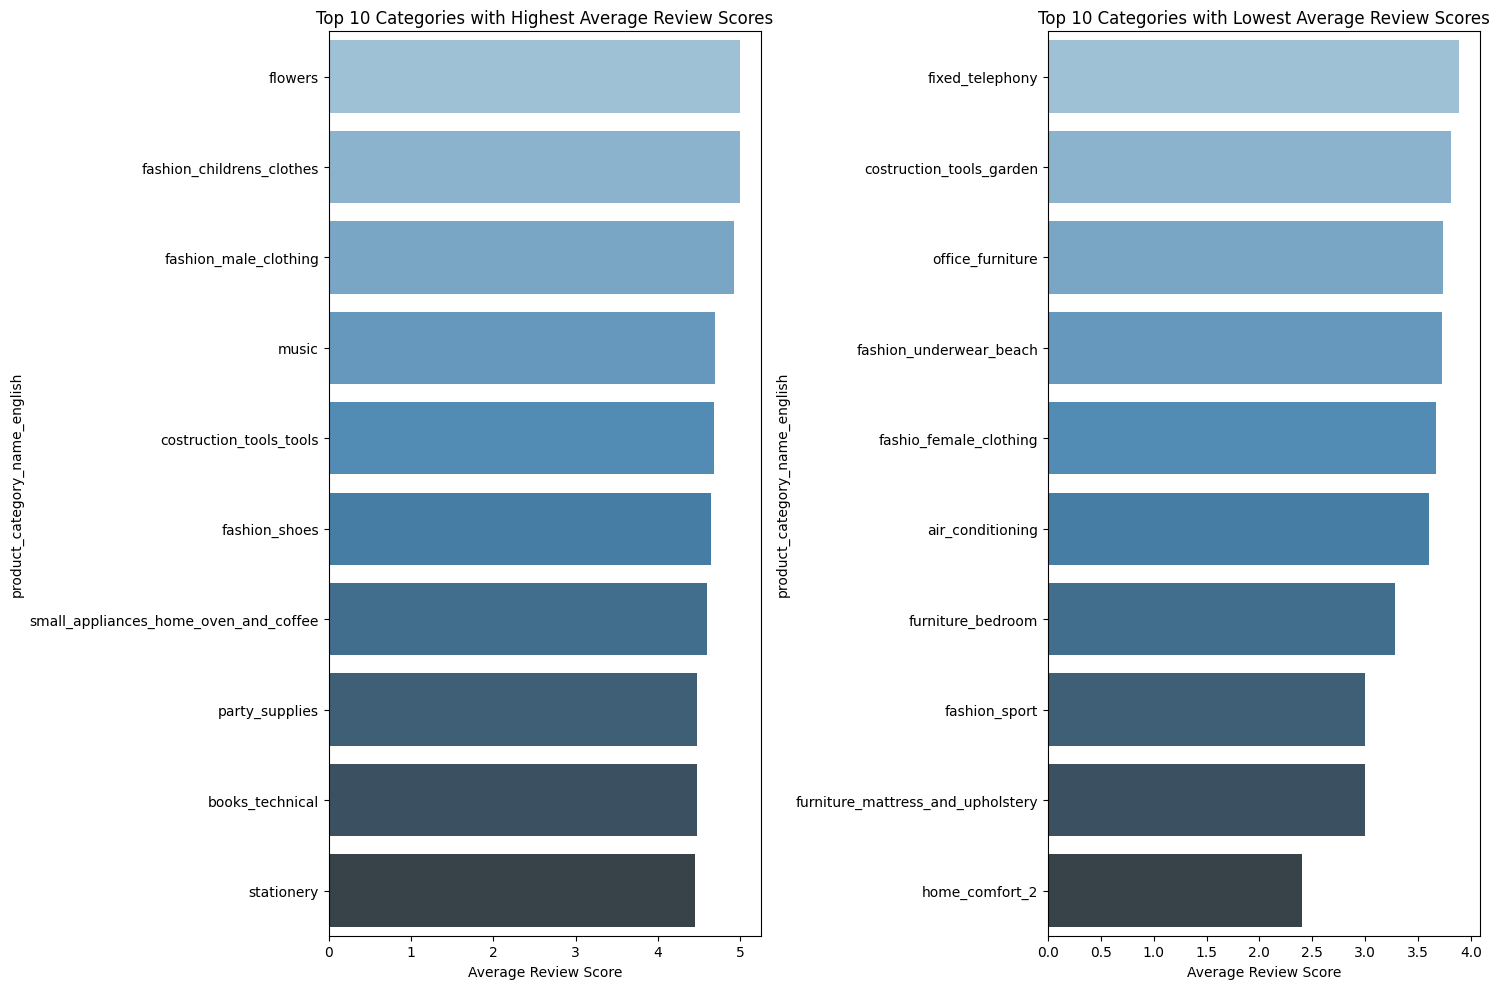

In [54]:
# Sort the scores for better visualization
average_review_scores = average_review_scores.sort_values()

# Get top 10 categories with highest and lowest average review scores
top_10 = average_review_scores.tail(10)
bottom_10 = average_review_scores.head(10)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Plot top 10 categories
sns.barplot(x=top_10.values[::-1], y=top_10.index[::-1], ax=axs[0], palette="Blues_d")
axs[0].set_title('Top 10 Categories with Highest Average Review Scores')
axs[0].set_xlabel('Average Review Score')

# Plot bottom 10 categories
sns.barplot(x=bottom_10.values[::-1], y=bottom_10.index[::-1], ax=axs[1], palette="Blues_d")
axs[1].set_title('Top 10 Categories with Lowest Average Review Scores')
axs[1].set_xlabel('Average Review Score')

# Display the plots
plt.tight_layout()
plt.show()

### 3. What are the sales trends for products by category over the last two years?

C:\Users\rafae\AppData\Local\Temp\ipykernel_26344\2204900101.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=sales_by_category.index, x=sales_by_category.values, palette="crest", orient='h')


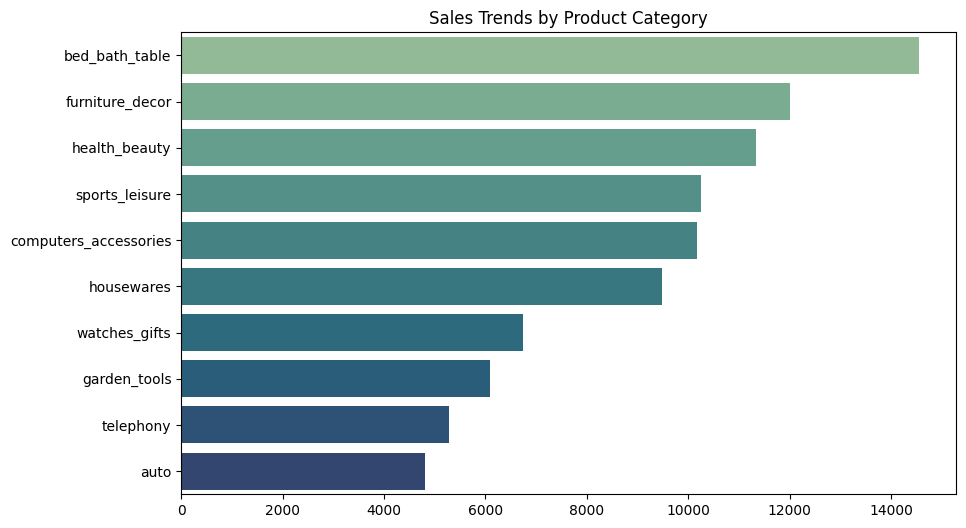

In [55]:
# Filter data for the last 2 years
last_2_years = all_df['order_approved_at'].max() - pd.DateOffset(years=2)
filtered_df = all_df[all_df['order_approved_at'] >= last_2_years]

# Sales trends for products
sales_by_category = filtered_df.groupby('product_category_name_english')['order_item_id'].sum().sort_values(ascending=False).head(10)

# Use Seaborn for the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(y=sales_by_category.index, x=sales_by_category.values, palette="crest", orient='h')
plt.title('Sales Trends by Product Category')
plt.ylabel('')
plt.xlabel('')
plt.show()

### 4. What is the geographical distribution of customers in the last year?

In [56]:
all_df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18              1   
1                    2017-10-18              1   
2                    2017-10-18              1   
3                    2018-08-13              1   
4                    2018-09-04              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   

  shipping_limit_date   price  freight_value     seller_city seller_state  \
0 2017-10-06 11:07:15   29.99           8.72            maua           SP   
1 2017-10-06 11:07:15   29.99           8.72            maua           SP   
2 2017-10-06 11:07:15   29.99           8.72            maua           SP   
3 2018-07-30 03:24:27  118.70          22.76  belo horizonte           SP   
4 2018-08-13 08:55:23  159.90          19.22         guariba           SP   

   payment_sequential payment_type  payment_value  review_score  \
0                   1  credit_card          18.12             4   
1                   3      voucher           2.00             4   
2                   2      voucher          18.59             4   
3                   1       boleto         141.46             4   
4                   1  credit_card         179.12             5   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             500.0               19.0                8.0              13.0   
1             500.0               19.0                8.0              13.0   
2             500.0               19.0                8.0              13.0   
3             400.0               19.0               13.0              19.0   
4             420.0               24.0               19.0              21.0   

                 customer_unique_id customer_city customer_state  \
0  7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
1  7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
2  7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
3  af07308b275d755c9edb36a90c618231     barreiras             BA   
4  3a653a41f6f9fc3d2a113cf8398680e8    vianopolis             GO   

  product_category_name_english zip_code_customer  customer_lat  customer_lng  \
0                    housewares              3149    -23.583452    -46.586284   
1                    housewares              3149    -23.583452    -46.586284   
2                    housewares              3149    -23.583452    -46.586284   
3         

In [162]:
# Assign the maximum and minimum longitude for the map
max_lon, min_lon = -30.943182612367426, -75

# Assign the maximum and minimum latitude for the map
max_lat, min_lat = 6.104935381074177, -33.71758386653152

# Filter the data frame 'all_df' to only include customers who had their orders within the last year
filter_customer_loc = all_df['order_approved_at'].max() - pd.DateOffset(years=1)

# Get the latitude of customers who had their orders within the last year
customer_lat = all_df['customer_lat'][all_df['order_approved_at'] >=  filter_customer_loc]

# Get the longitude of customers who had their orders within the last year
customer_lng = all_df['customer_lng'][all_df['order_approved_at'] >=  filter_customer_loc]

# Create a list of tuples, where each tuple contains the latitude and longitude of a customer
customer_loc = list(zip(all_df['customer_lat'], all_df['customer_lng']))

# Create a folium map object, centered at latitude -15 and longitude -50, with a zoom level of 3.5
map_customer = folium.Map(location=[-15, -50], 
                          zoom_start=3.5,     
                          min_lat=min_lat,
                          max_lat=max_lat,
                          min_lon=min_lon,
                          max_lon=max_lon,
                          max_bounds=True,
                          tiles="Cartodb dark_matter")

# Add a FastMarkerCluster to the map, which will group close markers together for better visualization
FastMarkerCluster(data=customer_loc).add_to(map_customer)

## Display the map
map_customer

In [159]:
# Filter 'all_df' to only include customers who had their orders within the last year, then group by latitude and longitude
# Count the number of orders for each location and keep only the first three columns
heat_customer_data = all_df[all_df['order_approved_at'] >= filter_customer_loc].groupby(['customer_lat','customer_lng'],as_index=False).count().iloc[:, :3]

# Create a folium map object
heatmap_customer = folium.Map(
    location=[-15, -50], 
    zoom_start=4.5, 
    tiles='cartodbdark_matter',
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    max_bounds=True
)

# Add a HeatMap to the map, which will display the density of customers at different locations
HeatMap(
    name='Mapa de Calor',
    data=heat_customer_data,
    radius=10,
    max_zoom=15
).add_to(heatmap_customer)

# Display the map
heatmap_customer

As you can see, customers are spread across more than half of Brazil, with most of them located near Sao Paulo.

## 5. Conclusion

Based on my analysis, here are the key takeaways:

1. The majority of products purchased by customers weigh less than 1 kilogram. This could indicate a preference for lightweight items or digital goods.
2. In terms of review scores, the top three categories are flowers, children’s fashion clothes, and male fashion clothing. These categories consistently receive high ratings from customers. On the other hand, home comfort (2nd category), furniture/mattresses/upholstery, and fashion sport are the three categories with the lowest average review scores.
3. The most popular product categories among Brazilian customers are bed/bath/table, furniture/decor, and health/beauty. These categories may represent essential and frequently used items in daily life.
4. Customers are widely distributed across more than half of Brazil, with a significant concentration near Sao Paulo. This city alone ordered for nearly 90,000 customers between 2017 and 2018.
5. August is the peak month for purchases, which could be related to specific events, holidays, or seasonal shopping habits.
Weekdays are the most popular days for making purchases. This could be due to the availability of customers or specific shopping habits during the workweek.
6. Afternoon is the most popular time of day for customers to make purchases. This could be when customers have free time or when they are most likely to engage in online shopping.
7. The majority of customers prefer to use credit cards for their purchases. This could indicate a preference for the convenience and security offered by credit card transactions.

In conclusion, businesses could focus on improving the quality of products in categories with lower review scores or consider offering promotions during peak shopping times.

In [167]:
all_df.to_csv(os.path.join(os.getcwd(),'dashboard/all_df.csv'))